# 2D Forward Slice Model

Kind of similar to what we were doing in `inverse.ipynb`.

Have 2D slice

For each angle
1. Convolve with 2D MTF
2. Take projection
3. Rotate slice
4. Repeat

Image width in mm is $w$.

Pixel size is $e$.

Frequency spacing is $\Delta k = 1/w$ line pairs per mm.

Nyquist frequency is $k_{\max} = 1/(2e)$, is your maximum spatial frequency.

Have $N_\text{pixels} = w/e$ and $k_{\max}/ {\Delta k} = N_\text{pixels} / 2$. 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftshift, fftfreq

# Image Processing
from skimage.transform import radon, rescale, iradon
from PIL import Image

# Data
from skimage.data import shepp_logan_phantom

In [11]:
# Generate Gaussian profiles
def gaussian(x, sigma):
    return np.exp(-x**2/(2*sigma**2))

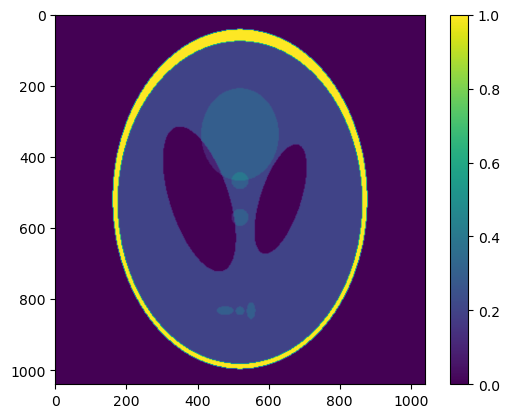

In [12]:
phantom = shepp_logan_phantom()
phantom = rescale(phantom, scale=2.6, mode='reflect')
plt.imshow(phantom)
plt.colorbar()

### Define 2D frequency filter

(1040, 1040)


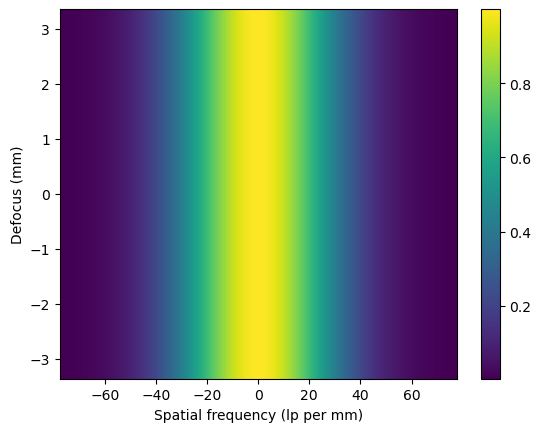

In [13]:
N_pixels = 1040
e = 6.45e-3 # Pixel size (mm)
nyquist_freq = 1/(2*e) # Nyquist frequency (line pairs per mm)

filter = np.zeros((N_pixels, N_pixels)) # dimensions: defocus, spatial frequency
frequencies = np.linspace(-nyquist_freq, nyquist_freq, N_pixels)
z = np.linspace(-N_pixels * e /2, +N_pixels * e /2, N_pixels) # defocuses (mm)

# populate 2D filter matrix
for i in range(len(filter)):
    filter[i] = gaussian(frequencies, 23)

K, Z = np.meshgrid(frequencies, z)
plt.pcolormesh(K, Z, filter)
plt.xlabel('Spatial frequency (lp per mm)')
plt.ylabel('Defocus (mm)')
print(filter.shape)
# plt.imshow() 
plt.colorbar()
fftshifted_filter = fftshift(filter, 1)

In [14]:
def forward_model(slice, fftshifted_MTF, angles):
    """_summary_

    Args:
        slice (_type_): _description_
        fftshifted_MTF (_type_): _description_
        angles (_type_): _description_

    Returns:
        _type_: _description_
    """
    image_width = slice.shape[0] # number of pixels
    sinogram = np.zeros((num_angles, image_width))
    im_PIL = Image.fromarray(slice)
    
    for i in range(num_angles):
        # rotates anticlockwise
        theta = angles[i]
        rotated = np.array(im_PIL.rotate(theta, expand=False)) 
        # convolves each line in slice with PSF of that depth --> do in Fourier domain
        fourier_image = fft(rotated) * fftshifted_MTF
        # plt.imshow(np.abs(fourier_image))
        filtered = ifft(fourier_image)

        # and then sums to get the projection
        # take line integral to get the projection
        projection = np.sum(filtered, axis=0)
        sinogram[i] = np.abs(projection)

    return sinogram

num_angles = 400
angles = np.linspace(0, 360, num_angles, endpoint=False)
simulated_sinogram = forward_model(phantom, fftshifted_filter, angles).T

In [1]:
plt.imshow(iradon(simulated_sinogram, -np.linspace(0, 360, 400, endpoint=False)))

NameError: name 'plt' is not defined

In [ ]:
phantom[200:230, 300:330] = 1
rotated = Image.fromarray(phantom).rotate(45.2, expand=False)
plt.imshow(np.array(rotated))

plt.plot(np.sum(rotated, axis=0))